<a href="https://colab.research.google.com/github/anandhulk/Quora-sincere-and-insincere-questions-classification/blob/main/Glove300_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,Dropout
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,GRU,GlobalMaxPool1D
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("/content/drive/MyDrive/dataset-quora/final-cleaned-dataset.csv")
data

,0,target
0,how do Quebec nationalist see their province a...,0
1,do you have an adopted dog how would you enco...,0
2,why do velocity affect time do velocity affec...,0
3,how do Otto von Guericke use the Magdeburg hem...,0
4,can I convert montra helicon d to a mountain b...,0
...,...,...
1306117,what other technical skill do you need as a co...,0
1306118,do MS in ECE have good job prospect in USA or ...,0
1306119,be foam insulation toxic,0
1306120,how can one start a research project base on b...,0


In [3]:
data.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [4]:
data['0']=data['0'].str.lower()

In [5]:
data=data.dropna()

In [6]:
train,test=train_test_split(data,random_state=42,test_size=0.2)
train.shape,test.shape

((1044896, 2), (261225, 2))

In [7]:
train.target.value_counts()

0    980179
1     64717
Name: target, dtype: int64

In [8]:
test.target.value_counts()

0    245133
1     16092
Name: target, dtype: int64

In [9]:
#stratifying the test dataset
test_sincere=test[test["target"]==0]
test_insincere=test[test["target"]==1]

test_sincere_under=test_sincere.sample(len(test_insincere),axis=0)

test=pd.concat([test_sincere_under,test_insincere],axis=0)

In [10]:
test.target.value_counts()

0    16092
1    16092
Name: target, dtype: int64

In [11]:
sincere=train[train["target"]==0]
insincere=train[train["target"]==1]

In [12]:
n=len(sincere)
insincere_over = insincere.sample(n, replace=True)

In [13]:
insincere_over.shape

(980179, 2)

In [14]:
data_over = pd.concat([sincere, insincere_over], axis=0)

In [15]:
data_over.target.value_counts()

0    980179
1    980179
Name: target, dtype: int64

In [16]:
data_over=data_over.sample(frac=1)
data_over=data_over.dropna()
data=data.dropna()

In [17]:
x=data_over['0']
y=data_over['target']
x.reset_index(inplace=True, drop=True)

test_x=test['0']
test_y=test['target']
test_x.reset_index(inplace=True, drop=True)

In [20]:
vocab_size=50000
max_len=100
tokenizer=Tokenizer(num_words=vocab_size)
fit_text=list(data['0'])

In [21]:
tokenizer.fit_on_texts(fit_text)
X_train=tokenizer.texts_to_sequences(x)

In [22]:
X_test=tokenizer.texts_to_sequences(test_x)

In [ ]:
# saving
with open('/content/drive/MyDrive/dataset-quora/tokenizer3.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# loading
with open('/content/drive/MyDrive/dataset-quora/tokenizer3.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [23]:
print(len(tokenizer.word_index))

169244


In [24]:
x[0]

'why do norwegians use the excuse of  be shy  for be downright impolite '

In [25]:
X_train[0]

[15, 4, 14469, 45, 2, 2951, 9, 1, 2288, 12, 1, 21204, 17024]

In [26]:
tokenizer.word_index['marriage']

563

In [27]:
X_train=pad_sequences(X_train,maxlen=max_len,padding='pre')

X_test=pad_sequences(X_test,maxlen=max_len,padding='pre')

print(X_train)
print("Training set: ",X_train.shape," Testing set: ",X_test.shape)

[[    0     0     0 ...     1 21204 17024]
 [    0     0     0 ...    25     3   535]
 [    0     0     0 ...    12 37096 13096]
 ...
 [    0     0     0 ...   892  4054   651]
 [    0     0     0 ...     7   244  1273]
 [    0     0     0 ...   825    83  1499]]
Training set:  (1960358, 100)  Testing set:  (32184, 100)


In [28]:
glove_embedded = "/content/drive/MyDrive/dataset-quora/glove.6B.300d.txt"

In [29]:
def getting_glove_embedding(filename):  #Getting glove embedding in a dictionary
    file = open(filename,'r')
    lines = file.readlines()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = np.asarray(parts[1:],dtype='float32')
        
    return(embedding)

In [30]:
def embedding_weights(vocab,raw_embedding):  #raw_embedding = getting_glove_embedding(filename)
    
    vocab_size = len(vocab)+1
    weight_matrix = np.zeros((vocab_size,300)) #each word with 300 dimensions
    
    for word , i in vocab.items():
        vector = raw_embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
            
    return(weight_matrix)

In [31]:
raw_embedding = getting_glove_embedding(glove_embedded)
print("<<<<<<< Raw Embedding Loaded >>>>>>>")
embedding_vectors = embedding_weights(tokenizer.word_index,raw_embedding)

<<<<<<< Raw Embedding Loaded >>>>>>>


In [52]:
gloveModel=Sequential([
    Embedding(len(tokenizer.word_index)+1,300,weights=[embedding_vectors]),
    Bidirectional(LSTM(128,return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64,return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(32,return_sequences=True)),
    GlobalMaxPool1D(),
    Dense(10,activation="relu"),
    Dropout(0.2),
    Dense(1,activation="sigmoid")
])

In [53]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

gloveModel.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=METRICS)


gloveModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         50773500  
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 256)        439296    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 64)        

In [54]:
gloveModel.fit(X_train,y,validation_data=[X_test,test_y],epochs=1,batch_size=1024)

1915/1915 [==============================] - 463s 238ms/step - loss: 0.2062 - accuracy: 0.9260 - precision: 0.9071 - recall: 0.9492 - val_loss: 0.3841 - val_accuracy: 0.8957 - val_precision: 0.9175 - val_recall: 0.8696


In [ ]:
#model save
gloveModel.save("/content/drive/MyDrive/dataset-quora/model_v3")

In [68]:
#load model
gloveModel=tf.keras.models.load_model("/content/drive/MyDrive/dataset-quora/model_v3", custom_objects=None, compile=True, options=None) 

In [69]:
y_pred2=gloveModel.predict(X_test)

In [82]:
threshold=0.45
y_p=[]
for i in y_pred2:
    if(i>=threshold):
        y_p.append(1)
    else:
        y_p.append(0)
confusion=confusion_matrix(test_y,y_p)

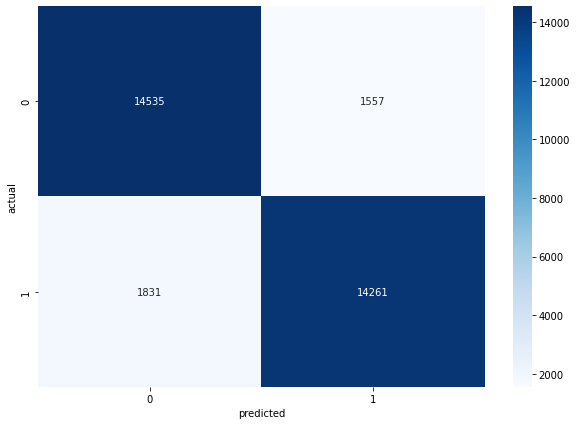

In [83]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion, annot=True,fmt='g',cmap='Blues')
plt.ylabel("actual")
plt.xlabel('predicted');

In [84]:
print("     Classification report of Glove LSTM model\n")
print(classification_report(test_y,y_p))

     Classification report of Glove LSTM model

              precision    recall  f1-score   support

           0       0.89      0.90      0.90     16092
           1       0.90      0.89      0.89     16092

    accuracy                           0.89     32184
   macro avg       0.89      0.89      0.89     32184
weighted avg       0.89      0.89      0.89     32184



In [85]:
def predict(question):
  question=tokenizer.texts_to_sequences(question)
  question=pad_sequences(question,maxlen=max_len,padding='pre')
  pred=gloveModel.predict(question)
  if(pred[0][0])>threshold:
    print("InSincere")
    print(pred[0][0],"%")
  else:
    print("Sincere")
    print(pred[0][0],"%")

In [87]:
q=input()
question=[]
question.append(q)
predict(question)

why india banned porn sites
Sincere
0.43172958 %
